## Trabajo Practico N°2

- Alvez Paula
- Bustos Daniel


Importamos las dependecias necesarias

In [218]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt

from sklearn import linear_model   # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import MinMaxScaler, StandardScaler    # Herramientas de polinomios

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from formulaic import model_matrix
from formulaic import Formula

# Paquetes para clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN



### 1. Preprocesamiento

1..1 Cargar en un DataFrame los datos del archivo FBRef2020-21.csv.

In [219]:
FBRef = pd.read_csv("FBRef2020-21.csv")
display(FBRef.head())


,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,29.0,1990.0,22,20,1777,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,32.0,1987.0,33,33,2889,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,Pape Abou Cisse,sn SEN,DF,Saint-Étienne,fr Ligue 1,24.0,1995.0,14,14,1260,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,David Abraham,ar ARG,DF,Eint Frankfurt,de Bundesliga,34.0,1986.0,14,14,1222,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,Francesco Acerbi,it ITA,DF,Lazio,it Serie A,32.0,1988.0,32,32,2813,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


2. Eliminar a los jugadores que jugaron menos de 500 minutos en la temporada (columna Min).

In [220]:
FBRef = FBRef.drop(FBRef[FBRef["Min"] < 500 ].index)

3. Eliminar los datos faltantes. Por ejemplo, eliminar columnas con más de 100 datos faltantes y
luego las filas con datos faltantes, o convertir los datos faltantes a algún valor apropiado.

In [221]:
cuenta_faltante = FBRef.isnull().sum()
#Recuperamos los indices de aquellas columnas que tienen mas de 100 datos faltantes
a_tirar = cuenta_faltante[cuenta_faltante > 100].index

FBRef = FBRef.drop(columns = a_tirar)
#Los datos restantes faltantes los convertimos en 0's
FBRef = FBRef.dropna()

4. Al finalizar la limpieza de datos, resetear los índices.

In [222]:
FBRef = FBRef.reset_index(drop=True)
display(FBRef.head())

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,29.0,1990.0,22,20,1777,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,32.0,1987.0,33,33,2889,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,Pape Abou Cisse,sn SEN,DF,Saint-Étienne,fr Ligue 1,24.0,1995.0,14,14,1260,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,David Abraham,ar ARG,DF,Eint Frankfurt,de Bundesliga,34.0,1986.0,14,14,1222,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,Francesco Acerbi,it ITA,DF,Lazio,it Serie A,32.0,1988.0,32,32,2813,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


5. Definir el DataFrame data_num que solo contenga las variables númericas, a partir de la
columna Ast/90, inclusive. Para clustering y clasificación no vamos a utilizar las variables
categóricas ni edad ni minutos jugados

In [223]:
#Recuperamos el indice de la primera columna que queremos  que este
indiceInicioCol = FBRef.columns.get_loc("Ast/90")
#Cortamos el dataset en base a este indice
data_num = FBRef.iloc[:,indiceInicioCol:]
display(data_num.head())
for x in data_num.columns:
    print(x)

,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,FKSht/90,np:G-xG,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,0.05,0.00,0.05,0.04,0.06,0.10,0.91,0.30,0.15,-0.06,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,0.00,0.09,0.09,0.01,0.05,0.06,0.47,0.16,0.00,0.04,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,0.00,0.00,0.00,0.00,0.08,0.09,0.93,0.21,0.00,-0.09,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,0.00,0.07,0.07,0.03,0.05,0.08,0.66,0.15,0.00,0.02,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,0.03,0.00,0.03,0.03,0.03,0.06,0.26,0.00,0.00,-0.03,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


Ast/90
npG/90
npG+A/90
xA/90
npxG/90
npxG+xA/90
Shots/90
SoTs/90
FKSht/90
np:G-xG
PassCmp/90
PassAtt/90
PassCmp%
TotDistPass/90
PrgDistPass/90
ShortCmp/90
ShortAtt/90
ShortCmp%
MedCmp/90
MedAtt/90
MedCmp%
LongCmp/90
LongAtt/90
LongCmp%
KeyPass/90
PassIntoThird/90
PassIntoBox/90
CrossIntoBox/90
ProgPass/90
LivePassAtt/90
DeadPassAtt/90
FKPassAtt/90
TBCmp/90
PassUnderPress/90
Switches/90
Crosses/90
GroundPass/90
LowPass/90
HighPass/90
LeftPass/90
RightPass/90
HeadPass/90
ThrowPass/90
OtherPartPass/90
OffsidePass/90
OutOBPass/90
PassesInt/90
PassesBlk/90
SCA/90
PassLiveSCA/90
PassDeadSCA/90
DribSCA/90
ShSCA/90
FoulSCA/90
DefSCA/90
GCA/90
PassLiveGCA/90
PassDeadGCA/90
DribGCA/90
ShGCA/90
FoulGCA/90
DefGCA/90
TklAtt/90
TklW/90
Def 3rdTkl/90
Mid 3rdTkl/90
Att 3rdTkl/90
TklvDribW/90
TklvDribAtt/90
Tkl%vDrib
DribPast/90
PressAtt/90
SuccPress/90
PressSucc%
Def 3rdPress/90
Mid 3rdPress/90
Att 3rdPress/90
Blocks/90
ShotBlocks/90
PassBlk/90
Interceptions/90
Clearances/90
ErrToShot/90
Touches/90
De

### 2. Clustering


6. Nuestro primer objetivo es realizar algún agrupamiento de jugadores con características similares.

(a) Seleccionar dos variables cualesquiera de los datos y realizar un gráfico de dispersión de
una variable en función de la otra para el total de las observaciones. ¿Pueden encontrar
fácilmente grupos distintos?

Vamos a elegir las variables  asistencias de goles esperados en 90 minutos("xAG/90") y  los goles esperados en 90 minutos("xG/90")

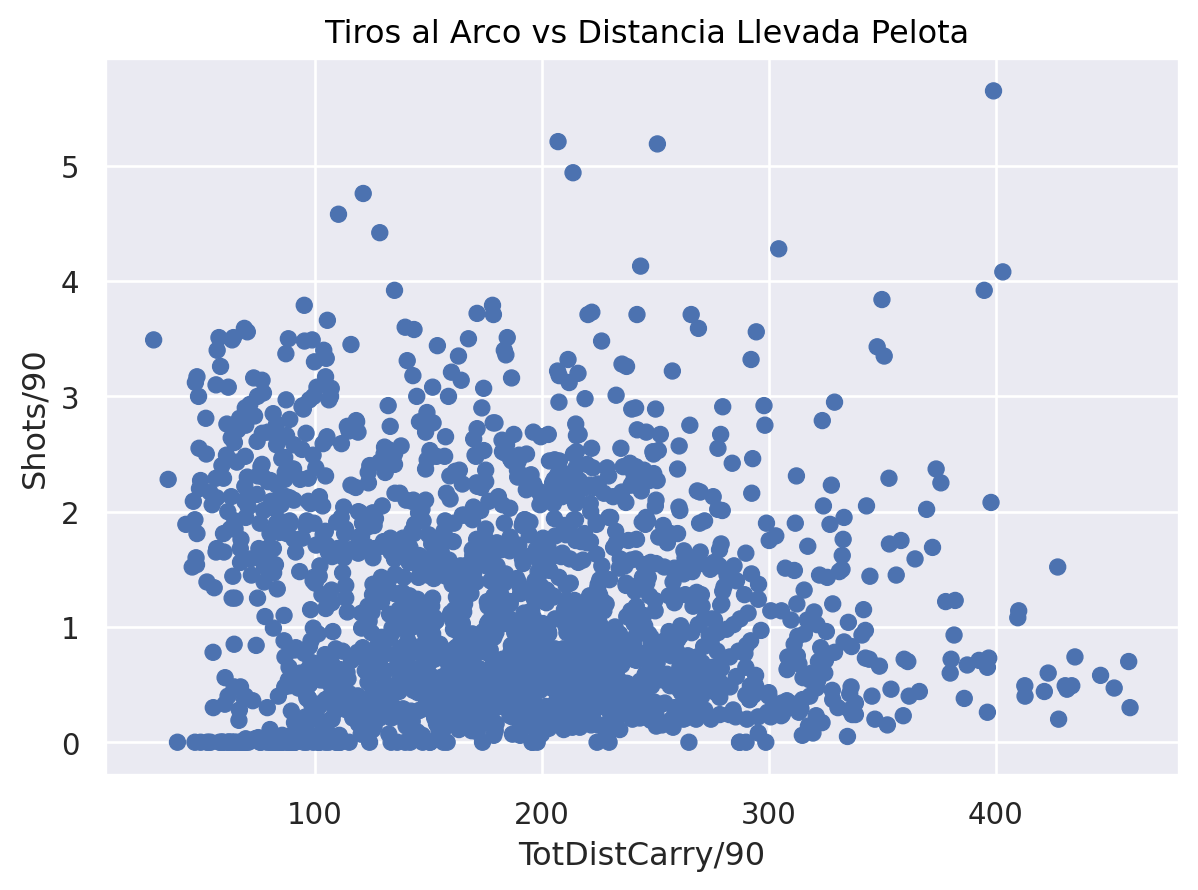

In [224]:
dataX =  "TotDistCarry/90"

dataY = "Shots/90"
so.Plot(data_num,x =dataX, y = dataY).add(so.Dot()).label(title= " Tiros al Arco vs Distancia Llevada Pelota")

No es extremadamente evidente que haya algun cluster particular, los datos estan demasiado junto,aunque es importante tener en cuenta la diferencia de escala entre ambos. A priori no pareciera que llevar mas tiempo la pelota implique una cantidad mayor de goles

b) Escalar los datos y realizar un análisis de componentes principales, quedándose solo con
las dos primeras componentes. Realizar un gráfico como el del punto anterior. ¿Cuántos
clusters puede distinguir en el gr´afico? ¿A qué características de los jugadores pueden corresponder los clusters? ¿Cómo pueden verificar su conjetura? (realizar una visualización o algún cálculo)

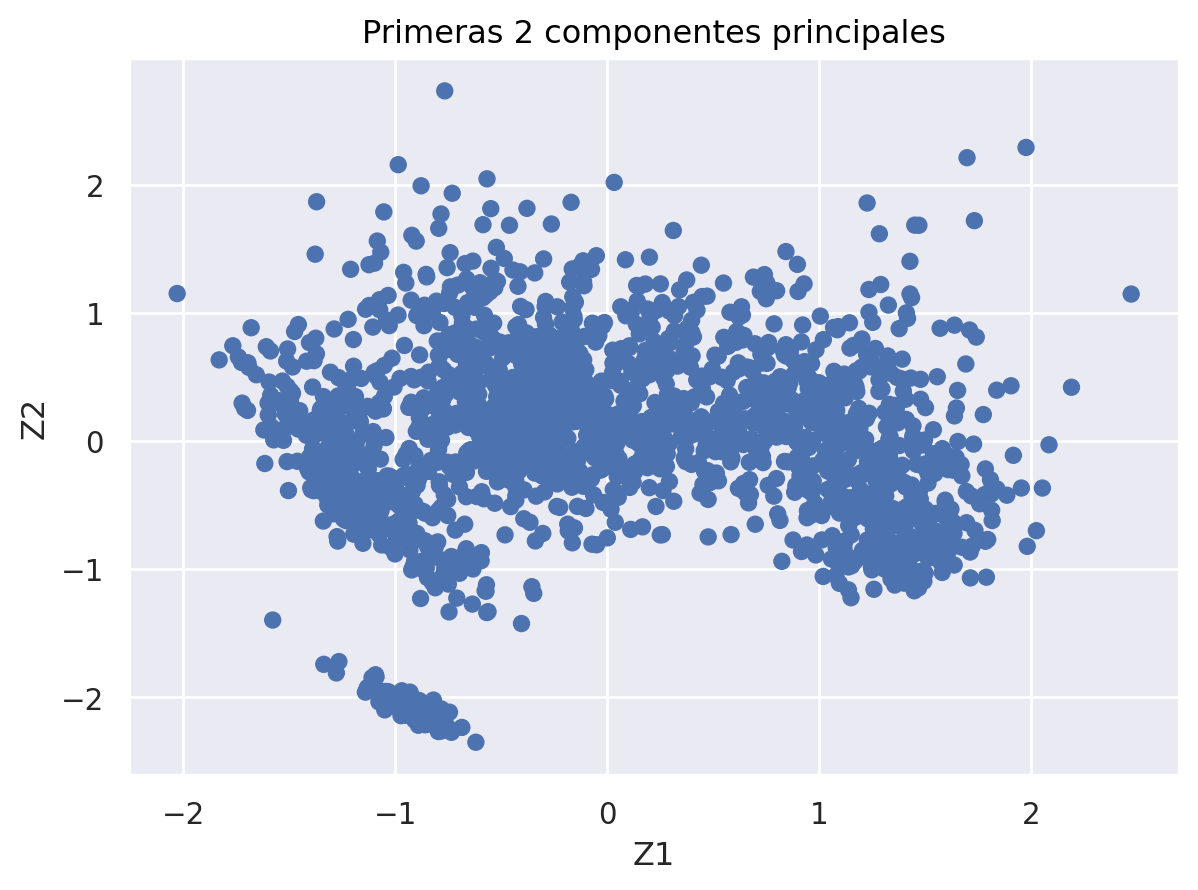

In [225]:
#Realizamos escalamiento min-Max

# Como tenemos datos en distintas escalas llevamos los datos a media 0 y varianza 1.
# Esta normalización se obtiene restando la media y dividiendo por el desvío estandar.


df_scaled = MinMaxScaler().fit_transform(data_num)
#Los llevamos a media 0
df_scaled = df_scaled - df_scaled.mean()


#Utilizamos PCA
myPCA = PCA(n_components=2)

CompPrincipales = pd.DataFrame(myPCA.fit_transform(df_scaled)).rename(columns = {0:"Z1",1:"Z2"})



so.Plot(CompPrincipales, x = "Z1", y = "Z2").add(so.Dot()).label(title= "Primeras 2 componentes principales")



Parece que obtenemos dos grandes clusters! Es interesante observar que estos no tienen la misma forma. Antes de sacar conclusiones, miremos que porcentaje de la varianza total estamos podiendo representar tan solo con dos componentes principales

In [226]:

print("Estamos explicando el {0:0.2f} % de la variabilidad total ".format(myPCA.explained_variance_ratio_.sum()))

Estamos explicando el 0.53 % de la variabilidad total 


Apenas un poco mas de la mitad!. Esto nos induce a pensar que nuestros datos tienen una variabilidad muy alta, cuando vemos a cada una de los datos originales

(c) Para la cantidad de clusters observados en el ítem anterior, realizar un agrupamiento por
k-medias, y colorear los puntos según las etiquetas obtenidas. ¿Coinciden las etiquetas
con lo esperado?

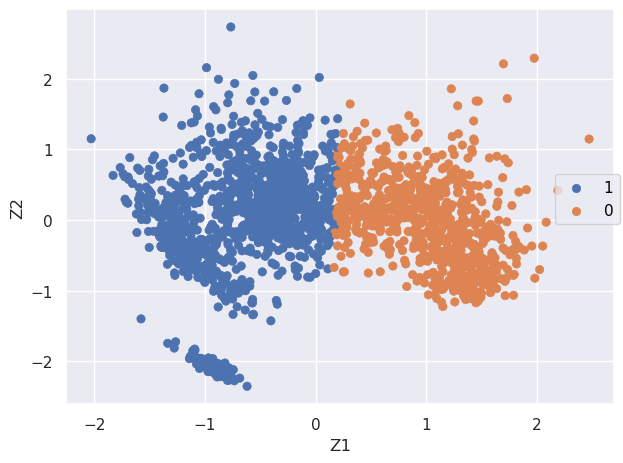

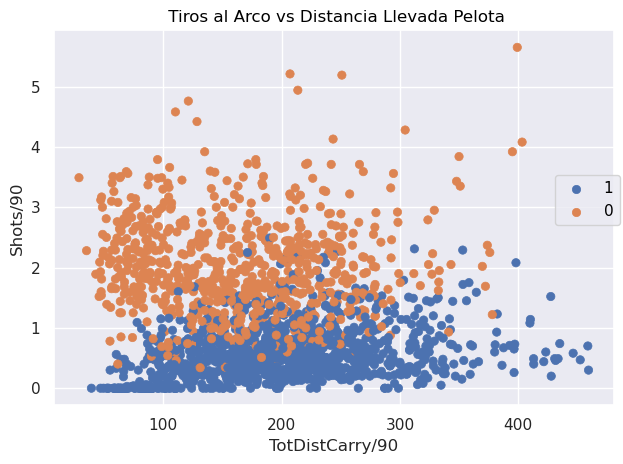

In [288]:
k = KMeans(n_clusters=2)
k.fit(CompPrincipales)
etiquetas = k.predict(CompPrincipales)
so.Plot(CompPrincipales, x = "Z1",y= "Z2", color = etiquetas.astype("str")).add(so.Dot()).show()
so.Plot(data_num,x =dataX, y = dataY,color = etiquetas.astype("str")).add(so.Dot()).label(title= " Tiros al Arco vs Distancia Llevada Pelota").show()

(d) Repetir el agrupamiento utilizando DBSCAN. ¿Cómo eligirían en este caso un valor de ε
apropiado?

Para tomar el epislon apropiado haremos lo siguiente:
- Calculamos la distancia de cada nodo a su vecino mas Cercano
- Graficamos estas distancias en orden creciente
- Usando el "metodo del codo" nos fijamos la distancia mas grande posible tal que el grafico no crezca extremadamente rapido, de esta manera tomamos la mayor cantidad de puntos posibles, sin necesariamente abarcar a los outliers

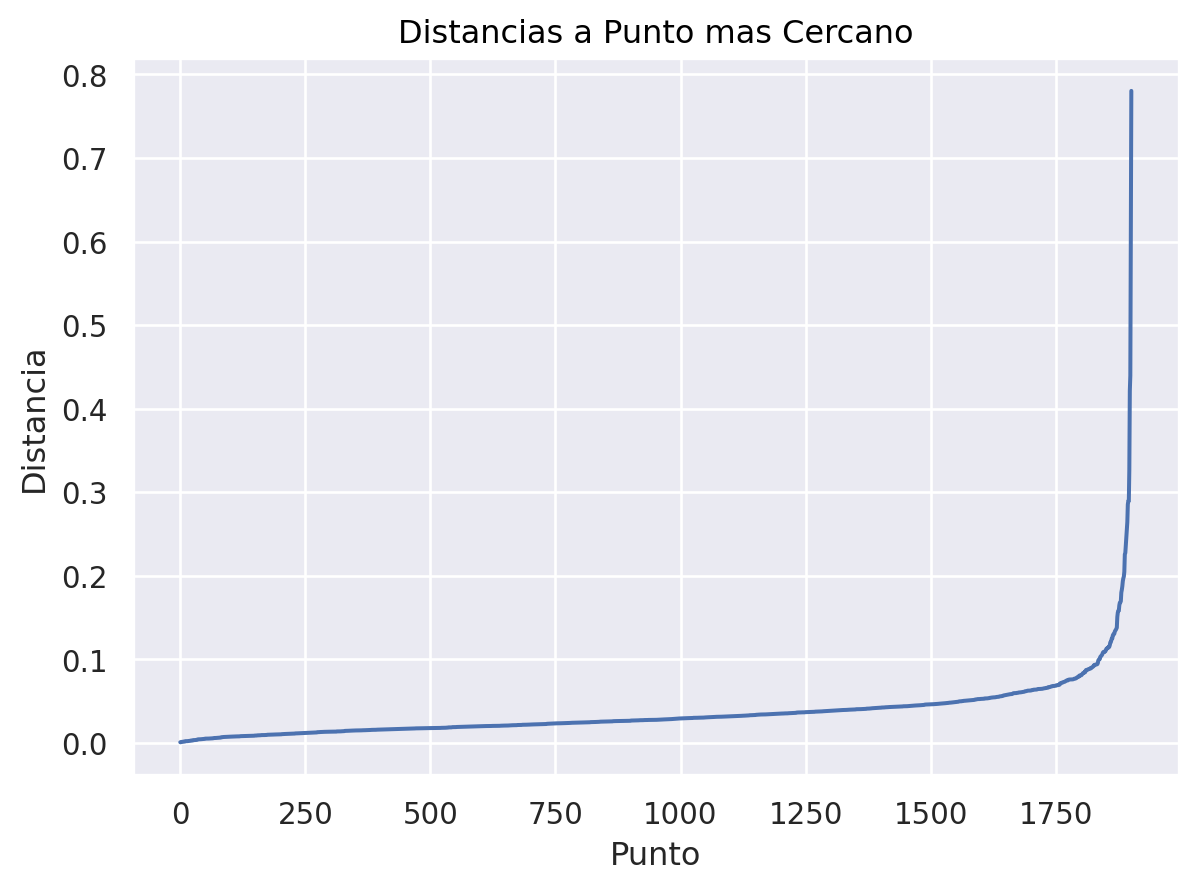

In [289]:
vecinos  = NearestNeighbors(n_neighbors=2) #Ponemos 2 porque la funcion incluye al punto mismo desde donde esta mirando
distancias, ind = vecinos.fit(CompPrincipales).kneighbors(CompPrincipales)
distancias = distancias[:,1]
distancias = np.sort(distancias,axis=0)

so.Plot(x = np.arange(len(distancias)),y = distancias).add(so.Line()).label(y = "Distancia",x = "Punto").label(title = "Distancias a Punto mas Cercano")

Recordemos que las distancias son tan pequeñas porque estamos trabajando sobre los datos escalados .

Basados en el grafico, vamos a elegir epsilon = 0.1

Ahora para seleccionar el otro hiperparametro, vamos a buscar para cada punto, cuantos otros puntos con distancia menor a epsilon tiene.
Luego tomaremos el promedio como nuestra eleccion de minPts

In [295]:
#Usamos esta funcion porque necesitamos computar rapidamente la distancia de todos a todos
#Cuando lo intentamos programar a mano, el tiempo de computo era irrazonable
from scipy.spatial.distance import cdist;

def puntos_por_epsilon(X, epsilon:int):
    #Lo escribimos de esta manera tan generica, ya que luego lo usareoms para puntos de n-dimensiones

    distancias = cdist(X.values,X.values)
    
    cantidad = np.sum(distancias < epsilon,axis=1) - 1  #Restamos uno para no contar al punto mismo
    
    
    return cantidad

rango = 0.1
cercanosAVG = puntos_por_epsilon(CompPrincipales,rango).mean()

print("La cantidad de puntos-media a una distancia menor o igual a {0} en el dataset es de {1}".format(rango,cercanosAVG))

La cantidad de puntos-media a una distancia menor o igual a 0.1 en el dataset es de 10.411146161934806


Como es claro que no podemos tomar una cantidad no entera de minPts, elegimos 11 como nuestro hiperparamentro.
Ahora si realizamos el DBSCAN y el grafico con el clustering resultante

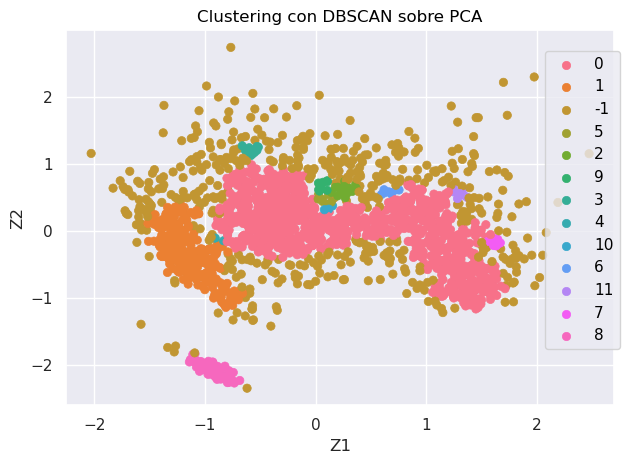

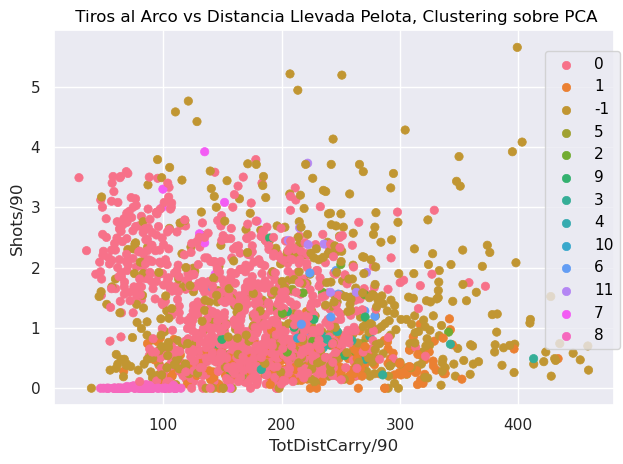

In [296]:
agrupamiento = DBSCAN(eps = 0.1,min_samples=10)
etiquetas = agrupamiento.fit_predict(CompPrincipales)

so.Plot(CompPrincipales, x = "Z1",y ="Z2",color = etiquetas.astype("str")).add(so.Dot()).label(title= "Clustering con DBSCAN sobre PCA").show()
so.Plot(data_num,x =dataX, y = dataY,color = etiquetas.astype("str")).add(so.Dot()).label(title= " Tiros al Arco vs Distancia Llevada Pelota, Clustering sobre PCA").show()


e) Utilizar DBSCAN para realizar agrupamiento utilizando como datos todas las variables
originales en vez de solo las dos componentes principales, modificando los valores de
epsilon y minPts convenientemente. ¿Con cuál de las dos opciones obtienen mejores
resultados?

Usaremos el mismo procedimiento para obtener nuestros hiperparametros
1ero Buscamos el epsilon con el metodo del codo

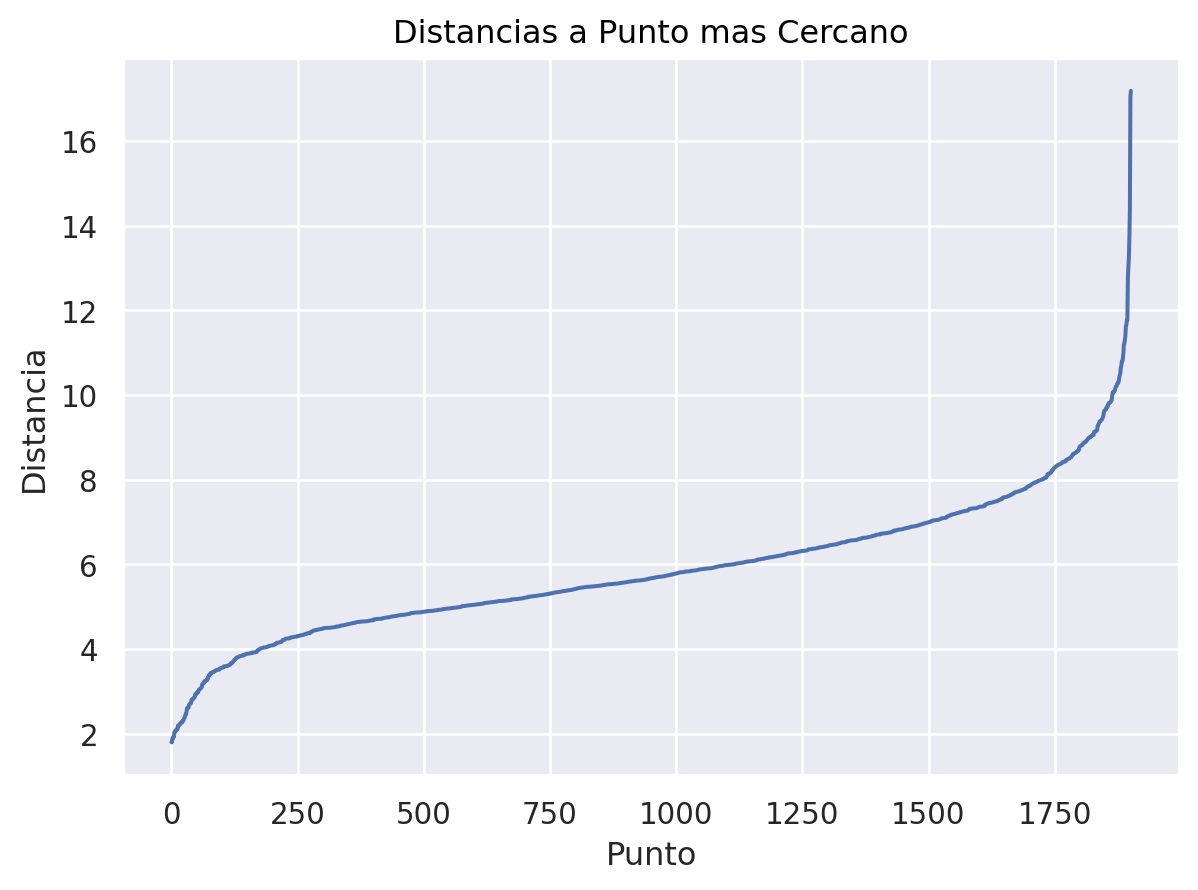

In [265]:
vecinos  = NearestNeighbors(n_neighbors=2) #Ponemos 2 porque la funcion incluye al punto mismo desde donde esta mirando
#Primero escalamos todos los datos, les damos media 0 y varianza 1

col = data_num.columns.tolist()
data_num_star = StandardScaler().fit_transform(data_num)
data_num_star = pd.DataFrame(data_num_star,columns=col)

distancias, ind = vecinos.fit(data_num_star).kneighbors(data_num_star)
distancias = distancias[:,1]
distancias = np.sort(distancias,axis=0)

so.Plot(x = np.arange(len(distancias)),y = distancias).add(so.Line()).label(y = "Distancia",x = "Punto").label(title = "Distancias a Punto mas Cercano")

Elejimos epsilon = 8. Buscamos ahora minPts

In [267]:
rango = 8
cercanosAVG = puntos_por_epsilon(data_num_star,rango).mean()

print("La cantidad de puntos-media a una distancia menor o igual a {0} en el dataset original es de {1}".format(rango,cercanosAVG))

La cantidad de puntos-media a una distancia menor o igual a 8 en el dataset original es de 89.4521556256572


Realizamos el agrupamiento con los hiperparametros encontrados

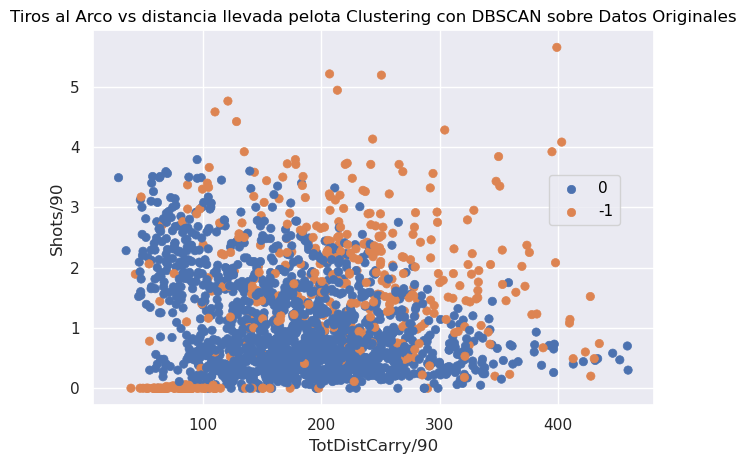

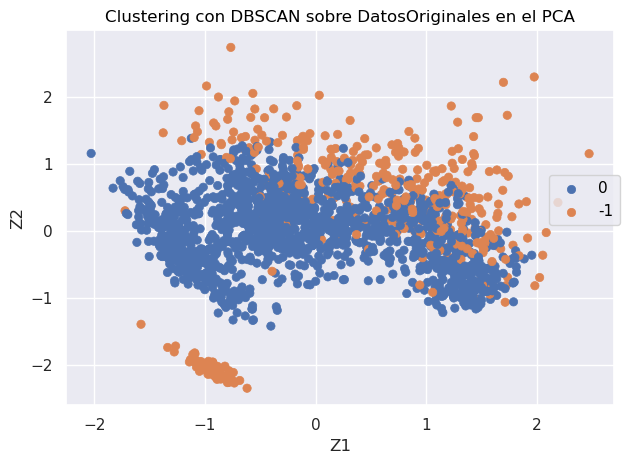

In [299]:
agrupamiento = DBSCAN(eps = 8,min_samples=89)
etiquetas = agrupamiento.fit_predict(data_num_star)

so.Plot(data_num, x = dataX,y =dataY,color = etiquetas.astype("str")).add(so.Dot()).label(title= "Tiros al Arco vs distancia llevada pelota Clustering con DBSCAN sobre Datos Originales").show()
so.Plot(CompPrincipales, x = "Z1",y ="Z2",color = etiquetas.astype("str")).add(so.Dot()).label(title= "Clustering con DBSCAN sobre DatosOriginales en el PCA").show()

### 3. Clasificación

7. Ahora queremos poder predecir la posición en la que juega cada jugador según sus datos
estadísticos utilizando K-NN . En la columna Pos encontramos la posición de los jugadores.
Para la mayoría de los jugadores se indica una única posición pero algunos jugadores tienen
dos posiciones. Para simplificar el an´alisis vamos a considerar una única posición por jugador.

(a) Definir la variable Pos_filt que es la columna Pos, pero donde los jugadores deben tener
una sola posición (pueden quedarse sólo con la primera posición de cada jugador o eliminar
los jugadores con dos posiciones, lo que consideren más conveniente).

In [285]:

Pos_filt = FBRef["Pos"]
#Nos quedamos solo con la primera posicion en el caso de tener mas de una
Pos_filt = [x.split(",")[0] for x in Pos_filt]



(b) Construir el DataFrame data_clasif que resulta de agregarle la columna de Pos_filt
al DataFrame data_num. Dividir data_num en un 80% para entrenamiento y un 20% para
testeo.

In [286]:
data_clasif = data_num
data_clasif["Pos_filt"] = Pos_filt
data_clasif_train,data_clasif_test = train_test_split(data_clasif,test_size=0.2)

(c) Aplicar un esquema de validación en el conjunto de entrenamiento para seleccionar el valor óptimo de K. (Esto puede demorar mucho si prueban muchos valores de K, pueden hacerlo hasta un valor máximo de K = 20.)
Sugerencia: puede resultar de ayuda KNeighborsClassifier de sklearn e investigar
esa librer´ıa para aplicar esquemas de validaci´on.

d) Para el valor de K obtenido, ¿cuál es el porcentaje de aciertos en el conjunto de testeo?

e) Repetir el procedimiento utilizando la primeras dos componentes principales en vez de
todas las variables. Indicar si se obtienen mejores resultados.

8. Repetir el mismo método de clasificación con el dataset de jugadoras de la liga inglesa femenina superleague2023.csv. Para esto, quedarse con la columna Pos y las columnas a partir de MP, inclusive. ¿Qué porcentaje de aciertos obtienen en este caso? ¿Puede modificarse el parámetro para obtener un porcentaje mayor?

### 4. Recomendaciones de Jugadores

Trabajamos ahora con el dataset transfermarkt_fbref_201920.csv que incluye la valuación de los jugadores. Una de las aplicaciones m´as comunes de análisis de datos en el fútbol es para obtener recomendaciones de jugadores a comprar.

In [231]:
data = pd.read_csv("transfermarkt_fbref_201920.csv",delimiter= ";")

(a) En 2021 Messi fue transferido del Barcelona al PSG. Básandose en los datos disponibles, recomendarle a Barcelona un jugador de características similares a Messi pero de menor valor

(b) Queremos elaborar un modelo para detectar jugadores “baratos”, es decir cuya valuación en el mercado (columna value) sea inferior a que la que nosotros estimemos. Para esto, quisiéramos ajustar el valor de mercado a partir de los datos de los jugadores (para estimar
la valuación pueden incorporar la edad entre las variables explicativas). El modelo que desarrollen puede basarse en redes neuronales o en otro modelo que consideren adecuado.

(c) Según el modelo desarrollado, entre los jugadores con un valor de mercado mayor a $100000, ¿quién es el más sobrevalorado? Es decir, el jugador con mayor diferencia entre el valor de mercado y el valor predicho por el modelo. ¿Y el más infravalorado?

d) El PSG quiere vender a Mbappé y reemplazarlo por otro jugador más barato. Hacer un listado de los 10 jugadores más parecidos a Mbapp´e seg´un el criterio que elijan. De esos 10 jugadores, según el modelo que desarrollaron en el ítem anterior, ¿a qué jugador recomendarían teniendo en cuenta la valuaci´on del mercado y la predicción del modelo? Para ese jugador, averiguar la valuación actual del jugador. ¿Hicieron una buena recomendación?